## Import libraries

In [38]:
import os
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import TensorBoard, EarlyStopping
import time

## Parameter settings

In [54]:
DATASET_PATH  = './data/data_1031'
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 130  # freeze the first this many layers for training
NUM_EPOCHS    = 50

WEIGHTS_FINAL = 'final-xception-final.h5'
TOP_LAYERS_CHECKPOINT_PATH = 'top-best_xcpt.hdf5'
FINE_TUNED_CHECKPOINT_PATH = 'finetuned-best_xcpt.hdf5'


## Define the training set and validation set

In [32]:

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 19937 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [33]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')


****************
Class #0 = cats
Class #1 = dogs
****************


## Create the base model

In [45]:

base_model = Xception(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = base_model.output
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# add a fully-connected layer
#x = Dense(1024, activation='relu', name='relu')(x)
# add logistic layer
output_layer = Dense(2, activation='softmax', name='softmax')(x)
final_model = Model(input=base_model.input, output=output_layer)

D:\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  if sys.path[0] == '':


## Load checkpoint

In [52]:
if os.path.exists(TOP_LAYERS_CHECKPOINT_PATH):
    final_model.load_weights(TOP_LAYERS_CHECKPOINT_PATH)
    print("Checkpoint '" + TOP_LAYERS_CHECKPOINT_PATH + "' loaded.")

Checkpoint 'top-best_xcpt.hdf5' loaded.


## Compile and train the model

In [46]:
# Train only the top layers we added, these parameters are initialized randomly.
for layer in base_model.layers:
    layer.trainable = False

final_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Save the TensorBoard logs.# Save the model after every epoch.
mc_top = ModelCheckpoint(TOP_LAYERS_CHECKPOINT_PATH, monitor='val_acc',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

logs = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

stp = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='auto')


In [48]:
t0 = time.time()
# train the model
hist_top = final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[mc_top, reduce_lr, stp,logs])

t1 = time.time()
print('time consumed:', (t1-t0))

Epoch 1/50
623/623 [==============================] - 461s 740ms/step - loss: 0.1555 - acc: 0.9378 - val_loss: 0.0716 - val_acc: 0.9816
Epoch 2/50
623/623 [==============================] - 452s 726ms/step - loss: 0.0905 - acc: 0.9665 - val_loss: 0.0497 - val_acc: 0.9873
Epoch 3/50
623/623 [==============================] - 453s 727ms/step - loss: 0.0835 - acc: 0.9692 - val_loss: 0.0335 - val_acc: 0.9919
Epoch 4/50
623/623 [==============================] - 453s 727ms/step - loss: 0.0791 - acc: 0.9715 - val_loss: 0.0367 - val_acc: 0.9917
Epoch 5/50
623/623 [==============================] - 453s 727ms/step - loss: 0.0800 - acc: 0.9712 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 6/50
623/623 [==============================] - 453s 728ms/step - loss: 0.0753 - acc: 0.9719 - val_loss: 0.0407 - val_acc: 0.9895
Epoch 7/50
623/623 [==============================] - 454s 728ms/step - loss: 0.0719 - acc: 0.9733 - val_loss: 0.0497 - val_acc: 0.9865
Epoch 8/50
623/623 [============================

## Visualize the training process

In [49]:
import matplotlib.pyplot as plt
# plot the figures

def visualize(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    
    fig = plt.figure(figsize = (8,4))
    
    # plot loss first
    ax_loss = fig.add_subplot(121)
    ax_loss.plot(loss, label = 'train_loss')
    ax_loss.plot(val_loss, label='validation_loss')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Loss')
    ax_loss.legend()
    
    # plot the accuracy
    ax_acc = fig.add_subplot(122)
    ax_acc.plot(acc, label = 'train_acc')
    ax_acc.plot(val_acc, label='validation_acc')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title('Accuracy')
    ax_acc.legend()
    
    plt.tight_layout()
    plt.show()



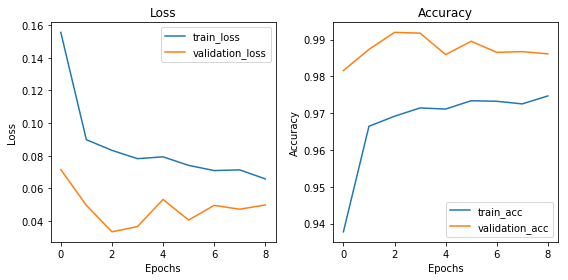

In [50]:
visualize(hist_top)

In [51]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
    


0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_193
13 block2_pool
14 batch_normalization_193
15 add_13
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_194
23 block3_pool
24 batch_normalization_194
25 add_14
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_195
33 block4_pool
34 batch_normalization_195
35 add_15
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_16
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn


## Release parameters from more layers to training

In [53]:
mc_fit = ModelCheckpoint(FINE_TUNED_CHECKPOINT_PATH, monitor='val_acc',
                          verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

if os.path.exists(FINE_TUNED_CHECKPOINT_PATH):
    final_model.load_weights(FINE_TUNED_CHECKPOINT_PATH)
    print ("Checkpoint '" + FINE_TUNED_CHECKPOINT_PATH + "' loaded.")

In [55]:
for layer in final_model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in final_model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
final_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(final_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [56]:
t2=time.time()

# train the model
hist_finetune = final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[mc_fit, reduce_lr, stp,logs])

t3 = time.time()
print('time consumed:', (t3-t2))

Epoch 1/50
623/623 [==============================] - 525s 842ms/step - loss: 0.0830 - acc: 0.9703 - val_loss: 0.0214 - val_acc: 0.9948
Epoch 2/50
623/623 [==============================] - 490s 787ms/step - loss: 0.0844 - acc: 0.9692 - val_loss: 0.0153 - val_acc: 0.9956
Epoch 3/50
623/623 [==============================] - 483s 776ms/step - loss: 0.0762 - acc: 0.9734 - val_loss: 0.0216 - val_acc: 0.9944
Epoch 4/50
623/623 [==============================] - 454s 729ms/step - loss: 0.0747 - acc: 0.9713 - val_loss: 0.0152 - val_acc: 0.9958
Epoch 5/50
623/623 [==============================] - 454s 729ms/step - loss: 0.0677 - acc: 0.9756 - val_loss: 0.0182 - val_acc: 0.9954
Epoch 6/50
623/623 [==============================] - 453s 727ms/step - loss: 0.0680 - acc: 0.9753 - val_loss: 0.0174 - val_acc: 0.9954
Epoch 7/50
623/623 [==============================] - 458s 734ms/step - loss: 0.0684 - acc: 0.9745 - val_loss: 0.0183 - val_acc: 0.9952
Epoch 8/50
623/623 [============================

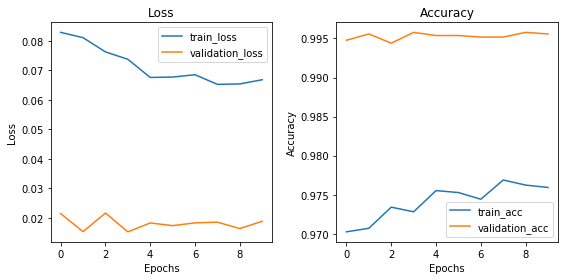

In [57]:
visualize(hist_finetune)


## Release more layers 2nd time

In [58]:
FREEZE_LAYERS_2 = 128

for layer in final_model.layers[:FREEZE_LAYERS_2]:
    layer.trainable = False
for layer in final_model.layers[FREEZE_LAYERS_2:]:
    layer.trainable = True
final_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])


In [59]:
FINE_TUNED_CHECKPOINT_PATH_MORE_LAYER = 'finetuned-best_Xcpt_more_layer.hdf5'

mt_fit = ModelCheckpoint(FINE_TUNED_CHECKPOINT_PATH_MORE_LAYER, monitor='val_acc',
                          verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

if os.path.exists(FINE_TUNED_CHECKPOINT_PATH_MORE_LAYER):
    final_model.load_weights(FINE_TUNED_CHECKPOINT_PATH_MORE_LAYER)
    print ("Checkpoint '" + FINE_TUNED_CHECKPOINT_PATH_MORE_LAYER + "' loaded.")

In [60]:
t4=time.time()

# train the model
hist_finetune_more_layer = final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[mt_fit, reduce_lr, stp,logs])

t5 = time.time()
print('time consumed:', (t5-t4))

Epoch 1/50
623/623 [==============================] - 462s 742ms/step - loss: 0.0665 - acc: 0.9749 - val_loss: 0.0166 - val_acc: 0.9958
Epoch 2/50
623/623 [==============================] - 455s 730ms/step - loss: 0.0687 - acc: 0.9772 - val_loss: 0.0154 - val_acc: 0.9962
Epoch 3/50
623/623 [==============================] - 455s 730ms/step - loss: 0.0599 - acc: 0.9786 - val_loss: 0.0166 - val_acc: 0.9954
Epoch 4/50
623/623 [==============================] - 455s 730ms/step - loss: 0.0594 - acc: 0.9787 - val_loss: 0.0174 - val_acc: 0.9954
Epoch 5/50
623/623 [==============================] - 460s 738ms/step - loss: 0.0559 - acc: 0.9787 - val_loss: 0.0175 - val_acc: 0.9956
Epoch 6/50
623/623 [==============================] - 469s 753ms/step - loss: 0.0593 - acc: 0.9780 - val_loss: 0.0182 - val_acc: 0.9952
Epoch 7/50
623/623 [==============================] - 469s 752ms/step - loss: 0.0578 - acc: 0.9789 - val_loss: 0.0164 - val_acc: 0.9958
Epoch 8/50
623/623 [============================

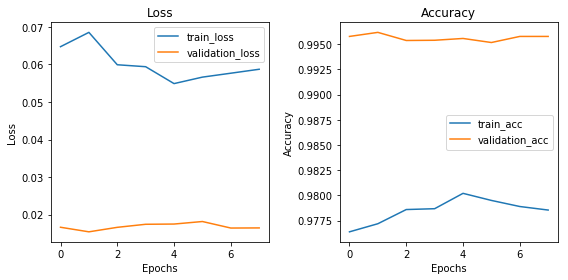

In [61]:
visualize(hist_finetune_more_layer)